In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import regex
import joblib
import gc
import optuna

import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV 
from sklearn.metrics import accuracy_score, confusion_matrix, mean_absolute_error, classification_report, roc_auc_score, roc_curve, f1_score, precision_recall_curve

## Фильтрация признаков

In [2]:
#Импорт датафрейма, разбиение на train и test
df = pd.read_pickle("data/ga_sessions_prepared.pkl")

df_prepared = df.copy()

x = df_prepared.drop(['event_value'], axis=1)
y = df_prepared['event_value']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [3]:
df_prepared.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1859938 entries, 0 to 1860041
Columns: 163 entries, event_value to visit_season_winter
dtypes: float64(160), int64(3)
memory usage: 2.3 GB


In [4]:
#Инициализация случайного леса
randfor = RandomForestClassifier(n_estimators=100, max_depth=8)
#clf.fit(x_train, y_train)

In [5]:
#Обучение
randfor.fit(x_train, y_train)

RandomForestClassifier(max_depth=8)

In [6]:
#Метрика ROC-AUC
y_proba = randfor.predict_proba(x_test)[:, 1]
print("ROC-AUC:", roc_auc_score(y_test, y_proba))

ROC-AUC: 0.6833451297562539


In [7]:
#Важность фич
f_imp_list = list(zip(x_train.columns, randfor.feature_importances_))
f_imp_list.sort(key=lambda x: x[1], reverse=True)
f_imp_list

[('visit_month', 0.09509482520656475),
 ('utm_campaign_freq', 0.08640028201875284),
 ('visit_number_std', 0.07850451336901193),
 ('utm_medium_referral', 0.07631272479209641),
 ('utm_source_freq', 0.0654973169509368),
 ('utm_adcontent_freq', 0.06509789978889677),
 ('visit_season_spring', 0.06217882245890923),
 ('organic_traffic', 0.05543165733543789),
 ('utm_keyword_freq', 0.038486064229426215),
 ('utm_medium_cpm', 0.02788545296032496),
 ('screen_size_std', 0.02264732132959411),
 ('utm_medium_cpc', 0.019191078821302908),
 ('social_ad', 0.01882663282314012),
 ('visit_day_cos', 0.016657511733680692),
 ('visit_season_summer', 0.01635910919812551),
 ('visit_day_sin', 0.015904741574804922),
 ('device_os_unknown_os', 0.015802385472005326),
 ('visit_season_winter', 0.015645679526034878),
 ('visit_season_fall', 0.015422140513071569),
 ('utm_medium_(none)', 0.012260386646171254),
 ('geo_city_freq', 0.011934438572570087),
 ('device_brand_freq', 0.010717461102126577),
 ('visit_hour_sin', 0.0102876

Признаки auto_model и auto_brand имеют низку ценность для модели не обладают большим влиянием на предсказательную способность.

In [8]:
#Удаление ненужных колонок
df_prepared = df_prepared.drop(df_prepared.filter(regex="^auto_brand").columns, axis=1)
df_prepared = df_prepared.drop(df_prepared.filter(regex="^auto_model").columns, axis=1)

In [9]:
#Разбиение на train и test
x = df_prepared.drop(['event_value'], axis=1)
y = df_prepared['event_value']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [10]:
#Обучение
randfor.fit(x_train, y_train)

RandomForestClassifier(max_depth=8)

In [11]:
#Метрика ROC-AUC
y_proba_without_auto = randfor.predict_proba(x_test)[:, 1]
print("ROC-AUC:", roc_auc_score(y_test, y_proba_without_auto))

ROC-AUC: 0.6874635922112332


In [12]:
#Важность фич
f_imp_list = list(zip(x_train.columns, randfor.feature_importances_))
f_imp_list.sort(key=lambda x: x[1], reverse=True)
f_imp_list

[('visit_month', 0.11400439522371371),
 ('visit_number_std', 0.09586213217802086),
 ('utm_campaign_freq', 0.09264333825391059),
 ('utm_source_freq', 0.08021361484058946),
 ('utm_medium_referral', 0.06694711684769762),
 ('utm_adcontent_freq', 0.062383654832084134),
 ('visit_season_spring', 0.04905944629874953),
 ('organic_traffic', 0.047878079993525766),
 ('utm_medium_cpm', 0.03094145223111596),
 ('utm_keyword_freq', 0.03007046876161379),
 ('screen_size_std', 0.02293319821364377),
 ('visit_season_fall', 0.02000442038357067),
 ('visit_season_winter', 0.019234331637965233),
 ('utm_medium_cpc', 0.019123160905111725),
 ('visit_day_cos', 0.018479482117235976),
 ('geo_city_freq', 0.015531653009147613),
 ('visit_day_sin', 0.015236179436758777),
 ('social_ad', 0.0145658145476679),
 ('utm_medium_(none)', 0.013724542744109391),
 ('device_os_unknown_os', 0.013279276399012559),
 ('visit_season_summer', 0.012756655020152018),
 ('device_browser_android', 0.01244750314671784),
 ('device_brand_freq', 0

Удаление признаков auto_model и auto_brand никак не повлияло на точность модели

In [13]:
#Удаление признаков visit_*
df_prepared = df_prepared.drop(df_prepared.filter(regex="^visit").columns, axis=1)

In [14]:
#Разбиение на train и test
x = df_prepared.drop(['event_value'], axis=1)
y = df_prepared['event_value']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [15]:
#Обучение
randfor.fit(x_train, y_train)

RandomForestClassifier(max_depth=8)

In [16]:
#Метрика ROC-AUC
y_proba_without_auto = randfor.predict_proba(x_test)[:, 1]
print("ROC-AUC:", roc_auc_score(y_test, y_proba_without_auto))

ROC-AUC: 0.673396831051257


In [17]:
#Важность фич
f_imp_list = list(zip(x_train.columns, randfor.feature_importances_))
f_imp_list.sort(key=lambda x: x[1], reverse=True)
f_imp_list

[('utm_campaign_freq', 0.15437865874327739),
 ('utm_adcontent_freq', 0.11314111955235222),
 ('utm_medium_referral', 0.1002722188995974),
 ('utm_source_freq', 0.09489213167281002),
 ('utm_keyword_freq', 0.09130746537209526),
 ('organic_traffic', 0.08843747637482297),
 ('utm_medium_cpm', 0.041438683030318404),
 ('screen_size_std', 0.03859905076201918),
 ('social_ad', 0.02930489756695926),
 ('device_os_unknown_os', 0.028645573639564863),
 ('geo_city_freq', 0.02690067376969887),
 ('utm_medium_cpc', 0.022297698262187988),
 ('device_brand_freq', 0.01849822170073135),
 ('utm_medium_(none)', 0.015397743616939989),
 ('device_browser_android', 0.014530189646786753),
 ('device_category_desktop', 0.01002426526117635),
 ('device_category_mobile', 0.008634199941354772),
 ('device_os_windows', 0.008395955346171116),
 ('device_browser_safari', 0.007630661348857479),
 ('device_browser_chrome', 0.007596772268963823),
 ('utm_medium_organic', 0.007560928939513038),
 ('utm_medium_banner', 0.006085456091941

Удаление признаков visit_ повлияло на точность модели, но не критично

In [18]:
#Удаление модели, очистка памяти
del randfor
gc.collect()

106

## Выбор модели

Поскольку линейных зависимостей между признаками и целевой переменной нет, будем использовать нелинейные модели. 
- RandomForestClassifier
- MLPClassifier
- LightGBM

In [19]:
#Разбиение датасета на тестовый и тренировочный
x = df_prepared.drop(['event_value'], axis=1)
y = df_prepared['event_value']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
x_sub, _, y_sub, _ = train_test_split(x_train, y_train, train_size=200_000, stratify=y_train, random_state=42)

In [20]:
#Выбор параметров для случайного леса
def tune_rf(X, y, n_trials=30, cv=3):
    def objective(trial):
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 50, 200),
            "max_depth": trial.suggest_int("max_depth", 5, 30),
            "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", 0.3, 0.5]),
            "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 4),
            "bootstrap": trial.suggest_categorical("bootstrap", [True, False]),
            "random_state": 42,
            "n_jobs": -1
        }
        model = RandomForestClassifier(**params)
        score = cross_val_score(model, X, y, cv=cv, scoring="roc_auc", n_jobs=-1).mean()
        return score

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials)

    best_params = study.best_params
    best_model = RandomForestClassifier(**best_params)
    return best_model, best_params

In [21]:
#Параметры лучшей модели
rf_best, rf_params = tune_rf(x_sub, y_sub)

[I 2025-09-12 17:52:37,362] A new study created in memory with name: no-name-4e4a6f2a-270e-4894-ad75-bcd4cf71aee6
[I 2025-09-12 17:52:46,484] Trial 0 finished with value: 0.6806988426409939 and parameters: {'n_estimators': 59, 'max_depth': 11, 'max_features': 'sqrt', 'min_samples_split': 8, 'min_samples_leaf': 3, 'bootstrap': True}. Best is trial 0 with value: 0.6806988426409939.
[I 2025-09-12 17:53:08,151] Trial 1 finished with value: 0.6783207104316502 and parameters: {'n_estimators': 110, 'max_depth': 7, 'max_features': 0.5, 'min_samples_split': 6, 'min_samples_leaf': 1, 'bootstrap': True}. Best is trial 0 with value: 0.6806988426409939.
[I 2025-09-12 17:53:24,250] Trial 2 finished with value: 0.6745229529075781 and parameters: {'n_estimators': 113, 'max_depth': 24, 'max_features': 'sqrt', 'min_samples_split': 9, 'min_samples_leaf': 3, 'bootstrap': True}. Best is trial 0 with value: 0.6806988426409939.
[I 2025-09-12 17:53:29,312] Trial 3 finished with value: 0.6640820409169602 and p

In [22]:
print("RF best params:", rf_params)

RF best params: {'n_estimators': 179, 'max_depth': 12, 'max_features': 0.3, 'min_samples_split': 3, 'min_samples_leaf': 3, 'bootstrap': False}


In [23]:
rf_best.fit(x_train, y_train)

RandomForestClassifier(bootstrap=False, max_depth=12, max_features=0.3,
                       min_samples_leaf=3, min_samples_split=3,
                       n_estimators=179)

In [24]:
#Метрика ROC-AUC
y_pred_proba_rf = rf_best.predict_proba(x_test)[:, 1]  # вероятность класса 1
roc_auc = roc_auc_score(y_test, y_pred_proba_rf)
print(f"RandomForest — ROC-AUC: {roc_auc:.4f}")

RandomForest — ROC-AUC: 0.6919


In [25]:
#Сохранение модели
joblib.dump(rf_best, "data/rf_best.pkl")

['data/rf_best.pkl']

In [26]:
#Удаление модели, очистка памяти
del rf_best
del rf_params
gc.collect()

776

In [27]:
def tune_mlp(X, y, n_trials=30, cv=3):
    def objective(trial):
        hidden_layer_sizes = trial.suggest_categorical(
        "hidden_layer_sizes", ["(100,)", "(100, 50)", "(200, 100, 50)"]
        )
        hidden_layer_sizes = eval(hidden_layer_sizes)

        params = {
            "hidden_layer_sizes": hidden_layer_sizes,
            "activation": trial.suggest_categorical("activation", ["relu", "tanh"]),
            "solver": trial.suggest_categorical("solver", ["adam", "sgd"]),
            "alpha": trial.suggest_float("alpha", 1e-4, 1e-2, log=True),
            "learning_rate": trial.suggest_categorical("learning_rate", ["constant", "adaptive"]),
            "learning_rate_init": trial.suggest_float("learning_rate_init", 1e-3, 0.05, log=True),
            "max_iter": trial.suggest_categorical("max_iter", [100, 200, 300, 500]),
        }
        model = MLPClassifier(**params)
        score = cross_val_score(model, X, y, cv=cv, scoring="roc_auc", n_jobs=-1).mean()
        return score

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials)

    best_params = study.best_params
    if isinstance(best_params["hidden_layer_sizes"], str):
        best_params["hidden_layer_sizes"] = eval(best_params["hidden_layer_sizes"])
    best_model = MLPClassifier(**best_params)
    return best_model, best_params


In [28]:
mlp_best, mlp_params = tune_mlp(x_sub, y_sub)

[I 2025-09-12 18:15:29,383] A new study created in memory with name: no-name-5909d505-4ed3-446b-9a0d-a7c272e2e889
[I 2025-09-12 18:15:53,788] Trial 0 finished with value: 0.6507904041584771 and parameters: {'hidden_layer_sizes': '(100, 50)', 'activation': 'relu', 'solver': 'sgd', 'alpha': 0.00013891698100109375, 'learning_rate': 'constant', 'learning_rate_init': 0.006047732213729111, 'max_iter': 100}. Best is trial 0 with value: 0.6507904041584771.
[I 2025-09-12 18:16:25,647] Trial 1 finished with value: 0.6646128513049899 and parameters: {'hidden_layer_sizes': '(100, 50)', 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0008990470840816344, 'learning_rate': 'constant', 'learning_rate_init': 0.013206970357528096, 'max_iter': 500}. Best is trial 1 with value: 0.6646128513049899.
[I 2025-09-12 18:16:40,493] Trial 2 finished with value: 0.6410922953925289 and parameters: {'hidden_layer_sizes': '(100,)', 'activation': 'relu', 'solver': 'sgd', 'alpha': 0.00047465157296336895, 'learning_r

In [29]:
print("MLP best params:", mlp_params)

MLP best params: {'hidden_layer_sizes': (200, 100, 50), 'activation': 'relu', 'solver': 'sgd', 'alpha': 0.005389145146532034, 'learning_rate': 'constant', 'learning_rate_init': 0.017821540590621857, 'max_iter': 500}


In [30]:
mlp_best.fit(x_train,y_train)

MLPClassifier(alpha=0.005389145146532034, hidden_layer_sizes=(200, 100, 50),
              learning_rate_init=0.017821540590621857, max_iter=500,
              solver='sgd')

In [31]:
#Метрика ROC-AUC
y_pred_proba_mlp = mlp_best.predict_proba(x_test)[:, 1]  # вероятность класса 1
roc_auc = roc_auc_score(y_test, y_pred_proba_mlp)
print(f"MLPClassifier — ROC-AUC: {roc_auc:.4f}")

MLPClassifier — ROC-AUC: 0.6781


In [32]:
#Сохранение модели
joblib.dump(mlp_best, "data/mlp_best.pkl")

['data/mlp_best.pkl']

In [33]:
#Очистка памяти
del mlp_best
del mlp_params
gc.collect()

1939

In [34]:
def tune_lgb(X, y, n_trials=30, cv=3):
    def objective(trial):
        params = {
            "num_leaves": trial.suggest_int("num_leaves", 31, 150),
            "max_depth": trial.suggest_int("max_depth", -1, 30),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
            "n_estimators": trial.suggest_int("n_estimators", 200, 1000),
            "feature_fraction": trial.suggest_float("feature_fraction", 0.6, 1.0),
            "bagging_fraction": trial.suggest_float("bagging_fraction", 0.6, 1.0),
            "bagging_freq": trial.suggest_int("bagging_freq", 0, 10),
            "lambda_l1": trial.suggest_float("lambda_l1", 0, 0.5),
            "lambda_l2": trial.suggest_float("lambda_l2", 0, 0.5),
            "min_child_samples": trial.suggest_int("min_child_samples", 10, 50),
            "random_state": 42,
            "n_jobs": -1
        }
        model = LGBMClassifier(**params)
        score = cross_val_score(model, X, y, cv=cv, scoring="roc_auc", n_jobs=-1).mean()
        return score

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials)

    best_params = study.best_params
    best_model = LGBMClassifier(**best_params)
    return best_model, best_params

In [35]:
lgb_best, lgb_params = tune_lgb(x_sub, y_sub)

[I 2025-09-12 19:18:06,939] A new study created in memory with name: no-name-1526b569-d106-4b93-8d31-584d31199ff9
[I 2025-09-12 19:18:27,904] Trial 0 finished with value: 0.6573385694984649 and parameters: {'num_leaves': 100, 'max_depth': 28, 'learning_rate': 0.04666220463353601, 'n_estimators': 728, 'feature_fraction': 0.7573928156372343, 'bagging_fraction': 0.836264084049895, 'bagging_freq': 3, 'lambda_l1': 0.4286163298644038, 'lambda_l2': 0.3910703261436283, 'min_child_samples': 47}. Best is trial 0 with value: 0.6573385694984649.
[I 2025-09-12 19:18:46,432] Trial 1 finished with value: 0.6442365721957847 and parameters: {'num_leaves': 81, 'max_depth': 18, 'learning_rate': 0.08987514079239776, 'n_estimators': 816, 'feature_fraction': 0.7344028466485427, 'bagging_fraction': 0.725627963969469, 'bagging_freq': 7, 'lambda_l1': 0.27269477388637925, 'lambda_l2': 0.28991558024286157, 'min_child_samples': 37}. Best is trial 0 with value: 0.6573385694984649.
[I 2025-09-12 19:18:54,229] Trial

In [36]:
print("LGB best params:", lgb_params)

LGB best params: {'num_leaves': 65, 'max_depth': 18, 'learning_rate': 0.012279121128815476, 'n_estimators': 525, 'feature_fraction': 0.6019654139069551, 'bagging_fraction': 0.9099320710092087, 'bagging_freq': 3, 'lambda_l1': 0.38846726935668674, 'lambda_l2': 0.3689564302076924, 'min_child_samples': 46}


In [37]:
lgb_best.fit(x_train,y_train)

[LightGBM] [Warning] feature_fraction is set=0.6019654139069551, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6019654139069551
[LightGBM] [Warning] lambda_l1 is set=0.38846726935668674, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.38846726935668674
[LightGBM] [Warning] lambda_l2 is set=0.3689564302076924, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3689564302076924
[LightGBM] [Warning] bagging_fraction is set=0.9099320710092087, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9099320710092087
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6019654139069551, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6019654139069551
[LightGBM] [Warning] lambda_l1 is set=0.38846726935668674, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.38846726935668674
[LightGBM] [Warning] lambda_l2 is

LGBMClassifier(bagging_fraction=0.9099320710092087, bagging_freq=3,
               feature_fraction=0.6019654139069551,
               lambda_l1=0.38846726935668674, lambda_l2=0.3689564302076924,
               learning_rate=0.012279121128815476, max_depth=18,
               min_child_samples=46, n_estimators=525, num_leaves=65)

In [38]:
#Метрика ROC-AUC
y_pred_proba_lgb = lgb_best.predict_proba(x_test)[:, 1]  # вероятность класса 1
roc_auc = roc_auc_score(y_test, y_pred_proba_lgb)
print(f"LightLGB — ROC-AUC: {roc_auc:.4f}")

[LightGBM] [Warning] feature_fraction is set=0.6019654139069551, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6019654139069551
[LightGBM] [Warning] lambda_l1 is set=0.38846726935668674, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.38846726935668674
[LightGBM] [Warning] lambda_l2 is set=0.3689564302076924, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3689564302076924
[LightGBM] [Warning] bagging_fraction is set=0.9099320710092087, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9099320710092087
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
LightLGB — ROC-AUC: 0.6969


In [39]:
#Сохранение модели
joblib.dump(lgb_best, "data/lgb_best.pkl")

['data/lgb_best.pkl']

In [40]:
#Очиста памяти
del lgb_best
del lgb_params
gc.collect()

1629

Лучшие результаты дала модель LightGBM

In [41]:
lgb = joblib.load('data/lgb_best.pkl')

In [42]:
#Обучение лучшей модели на всем тренирововчном сете
lgb.fit(x_train, y_train)

[LightGBM] [Warning] feature_fraction is set=0.6019654139069551, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6019654139069551
[LightGBM] [Warning] lambda_l1 is set=0.38846726935668674, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.38846726935668674
[LightGBM] [Warning] lambda_l2 is set=0.3689564302076924, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3689564302076924
[LightGBM] [Warning] bagging_fraction is set=0.9099320710092087, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9099320710092087
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6019654139069551, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6019654139069551
[LightGBM] [Warning] lambda_l1 is set=0.38846726935668674, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.38846726935668674
[LightGBM] [Warning] lambda_l2 is

LGBMClassifier(bagging_fraction=0.9099320710092087, bagging_freq=3,
               feature_fraction=0.6019654139069551,
               lambda_l1=0.38846726935668674, lambda_l2=0.3689564302076924,
               learning_rate=0.012279121128815476, max_depth=18,
               min_child_samples=46, n_estimators=525, num_leaves=65)

In [43]:
#Метрика roc-auc
y_pred_proba_lgb = lgb.predict_proba(x_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba_lgb)

[LightGBM] [Warning] feature_fraction is set=0.6019654139069551, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6019654139069551
[LightGBM] [Warning] lambda_l1 is set=0.38846726935668674, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.38846726935668674
[LightGBM] [Warning] lambda_l2 is set=0.3689564302076924, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3689564302076924
[LightGBM] [Warning] bagging_fraction is set=0.9099320710092087, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9099320710092087
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


In [44]:
#Перевод вероятностей в предсказания
y_pred_lgb = (y_pred_proba_lgb >= 0.5).astype(int)

In [45]:
#Главные метрики модели
print(f"LightLGB — ROC-AUC: {roc_auc:.4f}")
print(classification_report(y_test, y_pred_lgb))

LightLGB — ROC-AUC: 0.6969


C:\Users\Alexandra\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

         0.0       0.97      1.00      0.99    543045
         1.0       0.00      0.00      0.00     14937

    accuracy                           0.97    557982
   macro avg       0.49      0.50      0.49    557982
weighted avg       0.95      0.97      0.96    557982



C:\Users\Alexandra\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Alexandra\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Из-за того, что классы несбалансированны модель не находит более редкий класс. Она просто всегда предсказывает 0 и уже получает хорошую точность. Попробуем изменить порог вероятности

In [46]:
#Поиск оптимального порога
#Если precision или recall заданы, то оптимальный порог ищется по ним, если не заданы, то по f1 
#Здесь задано precision = 0.5
def find_best_threshold(y_true, y_proba, min_recall=None, min_precision=None, plot=True):
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_proba)
    thresholds = np.append(thresholds, 1.0)  # последний порог = 1

    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)

    # По умолчанию берем лучший порог по F1
    best_idx = np.argmax(f1_scores)

    # Если заданы ограничения на precision/recall — ищем допустимые пороги
    if min_recall is not None:
        candidates = np.where(recalls >= min_recall)[0]
        if len(candidates) > 0:
            best_idx = candidates[np.argmax(f1_scores[candidates])]

    if min_precision is not None:
        candidates = np.where(precisions >= min_precision)[0]
        if len(candidates) > 0:
            best_idx = candidates[np.argmax(f1_scores[candidates])]

    best_threshold = thresholds[best_idx]

    if plot:
        plt.figure(figsize=(8, 5))
        plt.plot(thresholds, precisions, label="Precision")
        plt.plot(thresholds, recalls, label="Recall")
        plt.plot(thresholds, f1_scores, label="F1-score")
        plt.axvline(best_threshold, color="red", linestyle="--", label=f"Best thr={best_threshold:.3f}")
        plt.xlabel("Threshold")
        plt.ylabel("Score")
        plt.legend()
        plt.title("Precision, Recall и F1-score в зависимости от порога")
        plt.show()

    return best_threshold, precisions[best_idx], recalls[best_idx], f1_scores[best_idx]


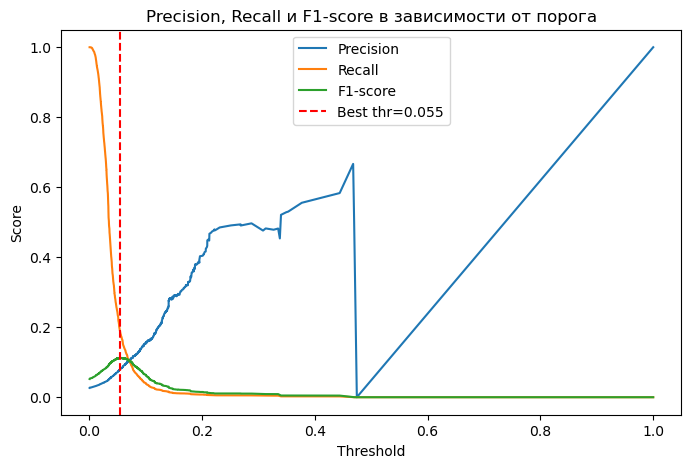

Лучший порог: 0.0546, Precision=0.080, Recall=0.188, F1=0.113


In [47]:
best_thr, p, r, f1 = find_best_threshold(y_test, y_pred_proba_lgb)
print(f"Лучший порог: {best_thr:.4f}, Precision={p:.3f}, Recall={r:.3f}, F1={f1:.3f}")

In [48]:
y_pred_lgb = (y_pred_proba_lgb >= best_thr).astype(int)

In [49]:
#Главные метрики модели с измененным порогом
print(f"LightLGB — ROC-AUC: {roc_auc:.4f}")
print(classification_report(y_test, y_pred_lgb))

LightLGB — ROC-AUC: 0.6969
              precision    recall  f1-score   support

         0.0       0.98      0.94      0.96    543045
         1.0       0.08      0.19      0.11     14937

    accuracy                           0.92    557982
   macro avg       0.53      0.56      0.54    557982
weighted avg       0.95      0.92      0.94    557982



## Baseline

In [50]:
df_raw = pd.read_csv("data/ga_sessions.csv")

C:\Users\Alexandra\AppData\Local\Temp\ipykernel_21384\980139229.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_raw = pd.read_csv("data/ga_sessions.csv")


In [51]:
df_hits = pd.read_csv("data/ga_hits-001.csv")

In [52]:
#Целевое действие
target_actions = [
    'sub_car_claim_click',
    'sub_car_claim_submit_click',
    'sub_open_dialog_click',
    'sub_custom_question_submit_click',
    'sub_call_number_click',
    'sub_callback_submit_click',
    'sub_submit_success',
    'sub_car_request_submit_click'
]

df_hits["event_value"] = df_hits["event_action"].isin(target_actions).astype(int)

In [53]:
#Добавление целевой переменной
target = df_hits.groupby("session_id")["event_value"].max().reset_index()
df_raw = df_raw.merge(target, on="session_id", how="left").fillna({"event_value": 0})

In [54]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1860042 entries, 0 to 1860041
Data columns (total 19 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   session_id                object 
 1   client_id                 object 
 2   visit_date                object 
 3   visit_time                object 
 4   visit_number              int64  
 5   utm_source                object 
 6   utm_medium                object 
 7   utm_campaign              object 
 8   utm_adcontent             object 
 9   utm_keyword               object 
 10  device_category           object 
 11  device_os                 object 
 12  device_brand              object 
 13  device_model              object 
 14  device_screen_resolution  object 
 15  device_browser            object 
 16  geo_country               object 
 17  geo_city                  object 
 18  event_value               float64
dtypes: float64(1), int64(1), object(17)
memory usage: 269.6+ MB


In [55]:
df_raw.nunique()

session_id                  1860042
client_id                   1391717
visit_date                      226
visit_time                    85318
visit_number                    537
utm_source                      293
utm_medium                       56
utm_campaign                    412
utm_adcontent                   286
utm_keyword                    1219
device_category                   3
device_os                        13
device_brand                    205
device_model                    104
device_screen_resolution       5039
device_browser                   57
geo_country                     166
geo_city                       2548
event_value                       2
dtype: int64

In [56]:
missing_values = (df_raw.isna().sum()/len(df_raw)*100).sort_values(ascending=False)
print('Процент пропущенных значений:')
missing_values

Процент пропущенных значений:


device_model                99.121633
utm_keyword                 58.174009
device_os                   57.533002
device_brand                19.740307
utm_adcontent               18.043410
utm_campaign                11.806346
utm_source                   0.005215
geo_city                     0.000000
geo_country                  0.000000
device_browser               0.000000
device_screen_resolution     0.000000
session_id                   0.000000
device_category              0.000000
client_id                    0.000000
utm_medium                   0.000000
visit_number                 0.000000
visit_time                   0.000000
visit_date                   0.000000
event_value                  0.000000
dtype: float64

Все пропуски заполним просто missing, колонки с большим количеством уникальных значений закодируем LabelEncoder, остальные OneHotEncoder

In [57]:
#Колонки для кодирования LabelEncoder
cols_to_encode_label = [
    "utm_source", "utm_campaign",
    "utm_adcontent", "utm_keyword", "device_brand", "geo_city"
]

for col in cols_to_encode_label:
    le = LabelEncoder()
    df_raw[col] = df_raw[col].astype(str).fillna("missing")  # заменим NaN на строку "missing"
    df_raw[col] = le.fit_transform(df_raw[col])


In [58]:
#Колонки для кодирования OneHotEncoder
cols_to_encode_onehot = ["device_category", "device_os", "device_browser", "utm_medium", "geo_country"]
df_raw[cols_to_encode_onehot] = df_raw[cols_to_encode_onehot].fillna('missing')

In [59]:
ohe = OneHotEncoder(sparse_output = False) 

In [60]:
ohe_categories = ohe.fit_transform(df_raw[cols_to_encode_onehot])

In [61]:
# Делаем DataFrame с новыми колонками
ohe_df = pd.DataFrame(ohe_categories, columns=ohe.get_feature_names_out(cols_to_encode_onehot), index=df_raw.index)
# Склеиваем с исходным датафреймом
df_raw = pd.concat([df_raw, ohe_df], axis=1)

In [62]:
#Колонки для удаления
cols_to_drop = ['session_id', 'client_id','visit_number', 'visit_date', 'visit_time',
                'utm_medium','device_category', 'device_os', 'device_model',
                'device_screen_resolution', 'device_browser', 'geo_country']
df_raw = df_raw.drop(cols_to_drop, axis = 1)

In [63]:
pd.set_option("display.max_columns", None)
df_raw.head()

,utm_source,utm_campaign,utm_adcontent,utm_keyword,device_brand,geo_city,event_value,device_category_desktop,device_category_mobile,device_category_tablet,device_os_(not set),device_os_Android,device_os_BlackBerry,device_os_Chrome OS,device_os_Firefox OS,device_os_Linux,device_os_Macintosh,device_os_Nokia,device_os_Samsung,device_os_Tizen,device_os_Windows,device_os_Windows Phone,device_os_iOS,device_os_missing,device_browser_(not set),device_browser_Amazon Silk,device_browser_Android,device_browser_Android Browser,device_browser_Android Runtime,device_browser_Android Webview,device_browser_Chrome,device_browser_Coc Coc,device_browser_Edge,device_browser_Firefox,device_browser_Instagram 158.0.0.30.123 Android,device_browser_Instagram 192.0.0.35.123 Android,device_browser_Instagram 192.0.0.37.119,device_browser_Instagram 194.0.0.36.172 Android,device_browser_Instagram 199.0.0.27.120,device_browser_Instagram 199.1.0.34.119 Android,device_browser_Instagram 201.0.0.23.111,device_browser_Instagram 202.0.0.23.119,device_browser_Instagram 202.0.0.37.123 Android,device_browser_Instagram 203.0.0.26.117,device_browser_Instagram 206.1.0.34.121 Android,device_browser_Instagram 207.0.0.28.118,device_browser_Instagram 208.0.0.26.131,device_browser_Instagram 208.0.0.32.135 Android,device_browser_Instagram 209.0.0.21.119 Android,device_browser_Instagram 212.0.0.38.119 Android,device_browser_Instagram 213.0.0.19.117,device_browser_Instagram 213.0.0.29.120 Android,device_browser_Instagram 216.0.0.12.135,device_browser_Instagram 216.1.0.21.137 Android,device_browser_Internet Explorer,device_browser_Iron,device_browser_Konqueror,device_browser_MRCHROME,device_browser_MT6735_TD,device_browser_Maxthon,device_browser_Mozilla,device_browser_Mozilla Compatible Agent,device_browser_MyApp,device_browser_NetFront,device_browser_Nokia501,device_browser_NokiaX2-02,device_browser_Opera,device_browser_Opera Mini,device_browser_Phantom Browser,device_browser_Puffin,device_browser_Safari,device_browser_Safari (in-app),device_browser_Samsung Internet,device_browser_SeaMonkey,device_browser_Threads 202.0.0.23.119,device_browser_UC Browser,device_browser_YaBrowser,device_browser_[FBAN,device_browser_com.vk.vkclient,device_browser_com.zhiliaoapp.musically,device_browser_helloworld,utm_medium_(none),utm_medium_(not set),utm_medium_CPM,utm_medium_Sbol_catalog,utm_medium_app,utm_medium_article,utm_medium_banner,utm_medium_blogger_channel,utm_medium_blogger_header,utm_medium_blogger_stories,utm_medium_catalogue,utm_medium_cbaafe,utm_medium_clicks,utm_medium_cpa,utm_medium_cpc,utm_medium_cpm,utm_medium_cpv,utm_medium_desktop,utm_medium_dom_click,utm_medium_email,utm_medium_fb_smm,utm_medium_google_cpc,utm_medium_info_text,utm_medium_landing,utm_medium_landing_interests,utm_medium_last,utm_medium_link,utm_medium_linktest,utm_medium_main_polka,utm_medium_medium,utm_medium_nkp,utm_medium_ok_smm,utm_medium_organic,utm_medium_outlook,utm_medium_partner,utm_medium_post,utm_medium_promo_sber,utm_medium_promo_sbol,utm_medium_push,utm_medium_qr,utm_medium_qrcodevideo,utm_medium_reach,utm_medium_referral,utm_medium_sber_app,utm_medium_smartbanner,utm_medium_smm,utm_medium_sms,utm_medium_social,utm_medium_static,utm_medium_stories,utm_medium_tablet,utm_medium_tg,utm_medium_users_msk,utm_medium_vk_smm,utm_medium_web_polka,utm_medium_yandex_cpc,geo_country_(not set),geo_country_Afghanistan,geo_country_Albania,geo_country_Algeria,geo_country_Andorra,geo_country_Angola,geo_country_Antigua & Barbuda,geo_country_Argentina,geo_country_Armenia,geo_country_Aruba,geo_country_Australia,geo_country_Austria,geo_country_Azerbaijan,geo_country_Bahrain,geo_country_Bangladesh,geo_country_Barbados,geo_country_Belarus,geo_country_Belgium,geo_country_Bosnia & Herzegovina,geo_country_Brazil,geo_country_Bulgaria,geo_country_Burkina Faso,geo_country_Burundi,geo_country_Cambodia,geo_country_Cameroon,geo_country_Canada,geo_country_Central African Republic,geo_country_Chad,geo_country_Chile,geo_country_Ch

In [64]:
#Разбиение датасета на train и test

x = df_raw.drop(['event_value'], axis=1)
y = df_raw['event_value']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [65]:
lr = LogisticRegression()

In [66]:
lr.fit(x_train, y_train)

C:\Users\Alexandra\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [67]:
#Метрика ROC-AUC
y_proba_raw = lr.predict_proba(x_test)[:, 1]
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba_raw):.4f}")

ROC-AUC: 0.6150


Качественное заполнение пропусков, работа с выбросами и аномалиями, генерация новых фич, а также обоснованный выбор модели и тюнинг помогли увеличить метрику roc-auc с 0.61 до 0.69, что составляет примерно 13%